In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_symbol = 'ADANIENT.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-01,1.364148,1.401700,1.334259,1.362615,-0.010452,1080397
2002-07-02,1.386372,1.390971,1.356484,1.373344,-0.010535,1016147
2002-07-03,1.371811,1.387139,1.364914,1.373344,-0.010535,980394
2002-07-04,1.379475,1.401700,1.379475,1.381008,-0.010593,972747
2002-07-05,1.388672,1.388672,1.372578,1.377942,-0.010570,974496
...,...,...,...,...,...,...
2024-04-25,3050.000000,3120.899902,3025.649902,3115.250000,3115.250000,1515529
2024-04-26,3119.899902,3129.899902,3066.050049,3080.399902,3080.399902,662764
2024-04-29,3110.000000,3110.500000,3051.500000,3081.199951,3081.199951,648544


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [7]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
168/168 [==============================] - 21s 12ms/step - loss: 0.0032
Epoch 2/50
168/168 [==============================] - 2s 11ms/step - loss: 0.0012
Epoch 3/50
168/168 [==============================] - 2s 11ms/step - loss: 0.0012
Epoch 4/50
168/168 [==============================] - 2s 11ms/step - loss: 8.8092e-04
Epoch 5/50
168/168 [==============================] - 2s 11ms/step - loss: 8.4096e-04
Epoch 6/50
168/168 [==============================] - 3s 15ms/step - loss: 8.2704e-04
Epoch 7/50
168/168 [==============================] - 2s 11ms/step - loss: 7.4580e-04
Epoch 8/50
168/168 [==============================] - 2s 11ms/step - loss: 7.0231e-04
Epoch 9/50
168/168 [==============================] - 2s 11ms/step - loss: 6.7646e-04
Epoch 10/50
168/168 [==============================] - 2s 11ms/step - loss: 5.8556e-04
Epoch 11/50
168/168 [==============================] - 2s 11ms/step - loss: 6.2776e-04
Epoch 12/50
168/168 [==============================] - 3s 15ms/

1/1 [==============================] - 0s 21ms/step


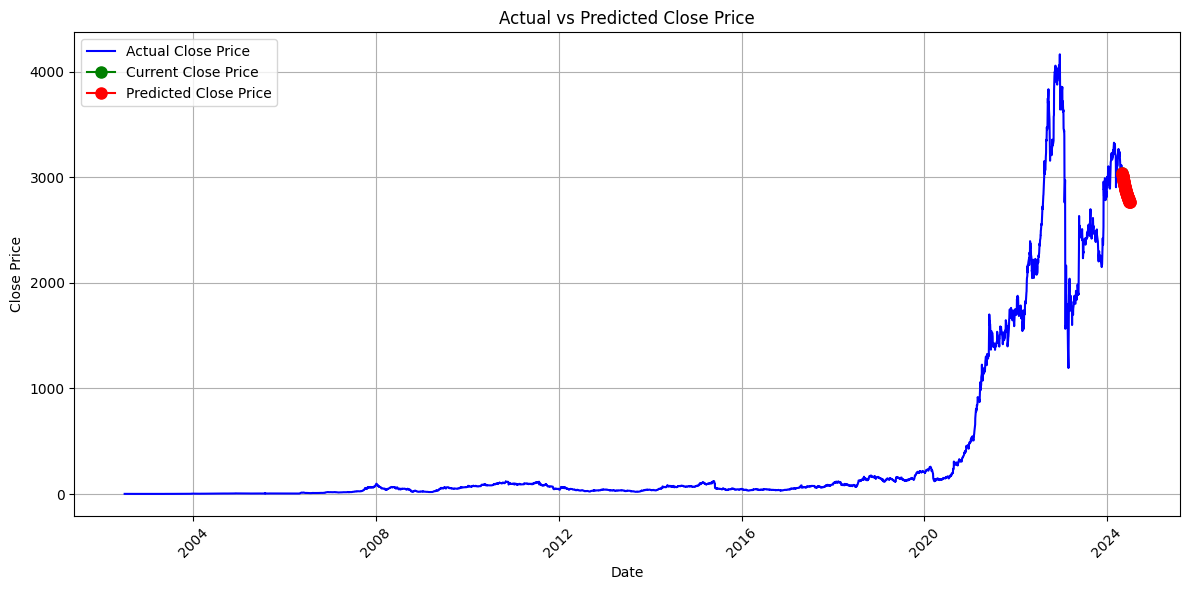

In [8]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
predicted_prices

array([3037.687 , 3024.784 , 3015.4827, 3007.974 , 3001.2131, 2994.7214,
       2988.3079, 2981.9185, 2975.5596, 2969.2573, 2963.0376, 2956.9207,
       2950.9194, 2945.0403, 2939.2847, 2933.6523, 2928.1394, 2922.7427,
       2917.4575, 2912.2805, 2907.2078, 2902.235 , 2897.3599, 2892.5781,
       2887.8882, 2883.2861, 2878.77  , 2874.3372, 2869.9856, 2865.7124,
       2861.5159, 2857.3938, 2853.3438, 2849.3647, 2845.454 , 2841.6099,
       2837.8308, 2834.115 , 2830.4607, 2826.867 , 2823.3313, 2819.853 ,
       2816.4302, 2813.062 , 2809.7466, 2806.4832, 2803.2695, 2800.1062,
       2796.9902, 2793.9219, 2790.899 , 2787.921 , 2784.9873, 2782.0962,
       2779.247 , 2776.439 , 2773.6714, 2770.9424, 2768.2522, 2765.5994],
      dtype=float32)

In [10]:
model.save('ADANIENT.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import joblib
joblib.dump(scaler, 'ADANIENT_minmax_scaler.pkl')

['ADANIENT_minmax_scaler.pkl']